# Image manipulation detection by MVSS-Net

This tutorial code provides a step-by-step demonstration of how to use a pre-trained MVSS-Net for detect manipulation in a given image. 

**Requirements and utils**

In [1]:
import os
import io
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from models.mvssnet import get_mvss
from models.resfcn import ResFCN
from common.tools import inference_single
from common.utils import calculate_pixel_f1
from apex import amp


**Configs**

In [2]:
fake_path = './data/demo/fake.jpg'
fake_gt_path = './data/demo/fake_gt.png'
real_path = './data/demo/real.jpg'
model_type = 'mvssnet'
mvssnet_path = './ckpt/mvssnet_casia.pt'
resfcn_path = './ckpt/resfcn_casia.pt'
resize = 512
th = 0.5

**Step 1. Load a pre-trained MVSS-Net**

In [3]:
if model_type == 'mvssnet':
    model = get_mvss(backbone='resnet50',
                     pretrained_base=True,
                     nclass=1,
                     sobel=True,
                     constrain=True,
                     n_input=3,
                     )
    checkpoint = torch.load(mvssnet_path, map_location='cpu')
elif model_type == 'fcn': 
    model = ResFCN()
    checkpoint = torch.load(resfcn_path, map_location='cpu')

model.load_state_dict(checkpoint, strict=True)
model.cuda()
model.eval()


load pretrain success
----------use sobel-------------
----------use constrain-------------
load pretrain success


MVSSNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

**Step 2. Load fake and real images**

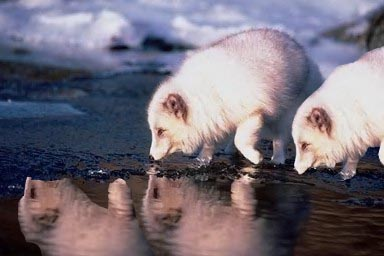

In [4]:
fake = cv2.imread(fake_path)
fake_size = fake.shape
fake_ = cv2.resize(fake, (resize, resize))
Image.fromarray(fake[:,:,::-1])

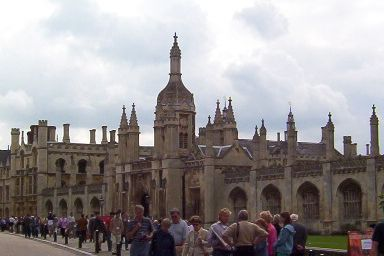

In [5]:
real = cv2.imread(real_path)
real_size = real.shape
real_ = cv2.resize(real, (resize, resize))
Image.fromarray(real[:,:,::-1])

**Step 3. Try to detect manipulation**

In [6]:
with torch.no_grad():
    fake_seg, _ = inference_single(img=fake_, model=model, th=0)
    fake_seg = cv2.resize(fake_seg, (fake_size[1], fake_size[0]))

In [7]:
with torch.no_grad():
    real_seg, _ = inference_single(img=real_, model=model, th=0)
    real_seg = cv2.resize(real_seg.astype(np.uint8), (real_size[1], real_size[0]))

**Step 4. Visualize detection results**

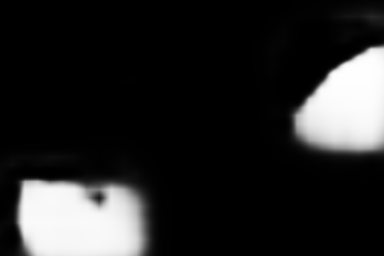

In [8]:
Image.fromarray((fake_seg).astype(np.uint8))

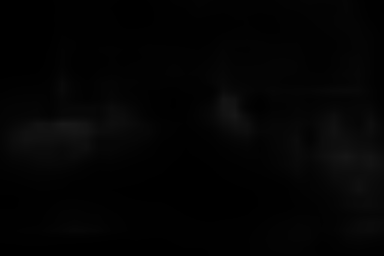

In [9]:
Image.fromarray((real_seg).astype(np.uint8))

**Step 5. Quantitative evaluation (only manipulated image)**

fake_img, pixel_f1: 0.6149, p: 0.4448, r: 0.9960


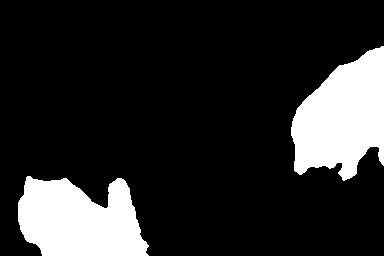

In [10]:
if os.path.exists(fake_gt_path):
    fake_gt = cv2.imread(fake_gt_path, 0) / 255.0
    f1, p, r = calculate_pixel_f1(fake_seg.flatten(),fake_gt.flatten())
    print("fake_img, pixel_f1: %.4f, p: %.4f, r: %.4f"%(f1, p, r))
else:
    print("groundtruth: %s not exists."%fake_gt_path)
Image.fromarray((fake_gt * 255).astype(np.uint8))